# WASP-80b broadband analysis 
## 5. Overview of the results
**Hannu Parviainen, Instituto de Astrofísica de Canarias**<br>

---

This notebook works as an appendix to Parviainen et al., *Ground based transmission spectroscopy of WASP-80b* (2017). The paper covers two analyses: a broadband analysis using three previously published datasets, and a transmission spectroscopy analysis using two GTC-observed spectroscopic time series, and this notebook covers a part of the broadband analysis.

**Last (significant) revision: 12.08.2017**

---

Now, we've run the eight broadband analyses (using either the notebooks or the script `/bin/fit_broadband`), and we're ready to take a look at the results.

We have eight simulation runs stored in an HDF5-file `RFILE_EXT`, named as

    ckwn[_ldtk]/{fc,mc}
    vkwn[_ldtk]/{fc,mc}
    ckrn[_ldtk]/{fc,mc}
    vkrn[_ldtk]/{fc,mc}
    
where `ck` stands for constant radius ratio, `vk` for passband-dependent radius ratio, `wn` for white noise (using only the T13 and M14 datasets), `rn` for red noise (using all the three datasets), and `_ldtk` is added to the run name if LDTk was used to constrain the limb darkening. The `fc` dataset contains the flattened MCMC chains, and `mc` contains the final MCMC walker population.

In [1]:
%pylab inline
%run __init__.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sb
from src.extcore import TZERO, RFILE_EXT, LPFTM, LPFRN, DFILE_EXT
from corner import corner
from scipy.stats import gaussian_kde as gkde
import astropy.time as at

In [3]:
from src.w80plots import wavelength_to_rgb

dff = pd.read_hdf(DFILE_EXT, 'transmission')
wl = dff.index.values
passbands = 'g r i z J H K'.split()
pb_centers = array([average(wl, weights=dff[c].values) for c in dff.columns])
pbb = sb.color_palette(wavelength_to_rgb(clip(400 + 0.35*(pb_centers-pb_centers.min()), 370, 700)))

In [4]:
def create_dataframe(df, lpf, burn=100, return_chains=False):
    ch = df.values.reshape([150,-1,lpf.ndim])
    fc = ch[:,burn:,:].reshape([-1,lpf.ndim])
    df = pd.DataFrame(fc, columns=lpf.ps.names)
    
    k2cols = [c for c in df.columns if 'k2' in c]
    kcols = [c.replace('k2', 'k') for c in k2cols]
    for ca,ck in zip(k2cols,kcols):
        df[ck] = sqrt(df[ca])
        
    q1cols = [c for c in df.columns if 'q1_' in c]
    q2cols = [c for c in df.columns if 'q2_' in c]
    ucols = [c.replace('q1', 'u') for c in q1cols]
    vcols = [c.replace('q2', 'v') for c in q2cols]

    for q1,q2,u,v in zip(q1cols,q2cols,ucols,vcols):
        a,b = sqrt(df[q1]), 2*df[q2]
        df[u] = a*b
        df[v] = a*(1-b)
        
    df['tc_mjd'] = at.Time(df.tc + TZERO, format='jd').mjd
    df['tc_centred'] = df.tc_mjd - floor(df.tc_mjd.mean())
    if not return_chains:
        return df
    else:
        return df, ch

def plot_violin(a1, a2, ax, c=0, w=0.5, color=None, ylabel='', slabels=['',''], offset=0.02):
    xmin = min(a1.min(), a2.min())
    xmax = max(a1.max(), a2.max())
    x = linspace(xmin, xmax, num=100)
    
    ppars = {'linewidth':0, 'edgecolor':'k'}
    if color:
        ppars['color'] = color
    
    for s,a,os,alpha in zip([-1,1],[a1,a2],[-offset,offset],[0.4,0.3]):
        xin = linspace(*percentile(a, [16,84]))
        gk = gkde(a, w)
        vl1 = gk(x)
        vl2 = gk(xin)
        vl2 /= 2.2 * vl1.max()
        vl1 /= 2.2 * vl1.max()
        ax.fill_betweenx(x, c+s*vl1+os, c+os, alpha=alpha, **ppars)
        ax.fill_betweenx(xin, c+s*vl2+os, c+os, color='k', alpha=0.25, linewidth=1)
        ax.plot(c+s*vl1+os, x, 'k', lw=0.5)
        ax.plot([c+os,c+os], [xmin,xmax], 'k', lw=0.5)
        ax.plot([c-os,c-os], [xmin,xmax], 'k', lw=0.5)
        ax.plot([c,c], [xmin,xmax], 'k', lw=0.5)
        if s < 0:
            ax.text(vl1[-1]+os-0.07, xmax, slabels[0], ha='right', va='top')
        else:
            ax.text(vl1[-1]+os+0.07, xmax, slabels[1], ha='left', va='top')

    setp(ax, ylabel=ylabel)

### Wavelength-independent radius ratio

In [5]:
lpfr = LPFRN()
lpfw = LPFTM()

wf = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckwn/fc'),      lpfw) # white noise, free ld
wl = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckwn_ldtk/fc'), lpfw) # white noise, with LDTk
rf = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn/fc'),      lpfr) # red noise, free ld
rl = create_dataframe(pd.read_hdf(RFILE_EXT, 'ckrn_ldtk/fc'), lpfr) # red noise, with LDTk

### System parameters for white noise and red noise runs

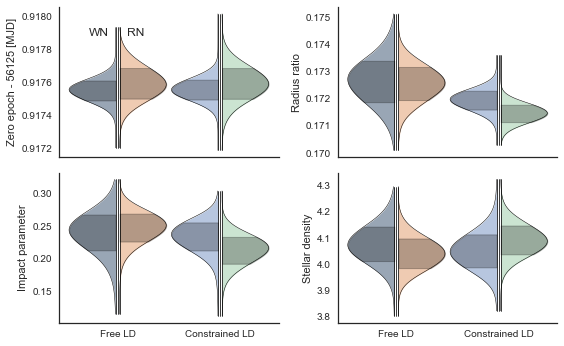

In [6]:
pars = 'tc_centred k_w b rho'.split()
pnames = 'Zero epoch - 56125 [MJD], Radius ratio, Impact parameter, Stellar density'.split(', ')

fig, axs = subplots(2,2, figsize=(8,5))
for i,(p,l) in enumerate(zip(pars, pnames)):
    slabels = ['WN', 'RN'] if i==0 else ['','']
    plot_violin(wf[p], rf[p], axs.flat[i], ylabel=l, slabels=slabels)
    plot_violin(wl[p], rl[p], axs.flat[i], c=1, ylabel=l)
setp(axs, xticks=[])
setp(axs[1,:], xticks=[0,1], xticklabels='Free LD, Constrained LD'.split(', '))
sb.despine(fig)
fig.tight_layout()

### Limb darkening for the white noise runs

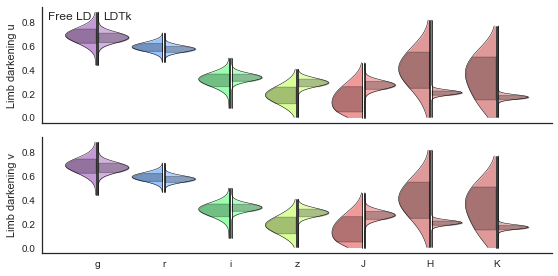

In [8]:
ucols = [c for c in wf if 'u_' in c]
vcols = [c for c in wf if 'u_' in c]

fig,ax = subplots(2,1, figsize=(8,4))
for i,(u,v) in enumerate(zip(ucols,vcols)):
    plot_violin(wf[u], wl[u], ax=ax[0], c=i, color=pbb[i], ylabel='Limb darkening u', slabels=(['Free LD','LDTk'] if i==0 else ['','']))
    plot_violin(wf[v], wl[v], ax=ax[1], c=i, color=pbb[i], ylabel='Limb darkening v')
sb.despine(fig)
setp(ax[0], xticks=[])
setp(ax[1], xticks=arange(len(passbands)), xticklabels=passbands)
fig.tight_layout()

### Limb darkening for the red noise runs

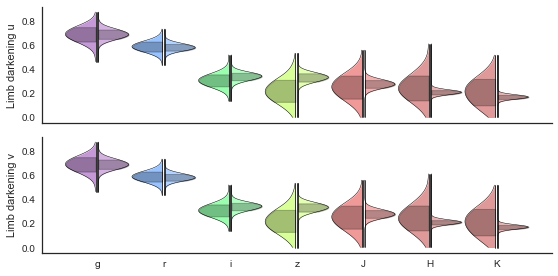

In [9]:
fig,ax = subplots(2,1, figsize=(8,4))
for i,(u,v) in enumerate(zip(ucols,vcols)):
    plot_violin(rf[u], rl[u], ax=ax[0], c=i, color=pbb[i], ylabel='Limb darkening u')
    plot_violin(rf[v], rl[v], ax=ax[1], c=i, color=pbb[i], ylabel='Limb darkening v')
sb.despine(fig)
setp(ax[0], xticks=[])
setp(ax[1], xticks=arange(len(passbands)), xticklabels=passbands)
fig.tight_layout()

### Corner plots

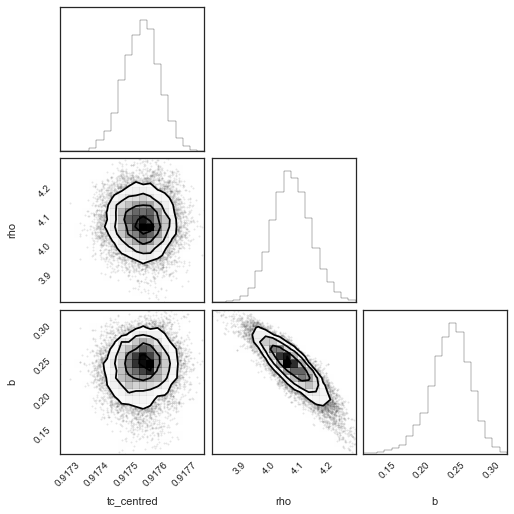

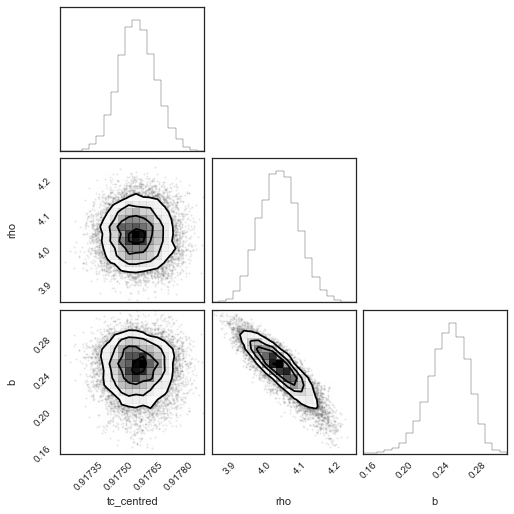

In [10]:
corner(wf['tc_centred rho b'.split()]);
corner(rf['tc_centred rho b'.split()]);

## Wavelength-dependent radius ratio

In [11]:
lpfr = LPFRN(constant_k=False)
lpfw = LPFTM(constant_k=False)

wf = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkwn/fc'),      lpfw) # white noise, free ld
wl = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkwn_ldtk/fc'), lpfw) # white noise, with LDTk
rf = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkrn/fc'),      lpfr) # red noise, free ld
rl = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkrn_ldtk/fc'), lpfr) # red noise, with LDTk

kcols = [c for c in wf.columns if 'k_' in c]
k2cols = [c for c in wf.columns if 'k2_' in c]

In [12]:
rl, rc = create_dataframe(pd.read_hdf(RFILE_EXT, 'vkrn_ldtk/fc'), lpfr, return_chains=True) # red noise, with LDTk


### System parameters

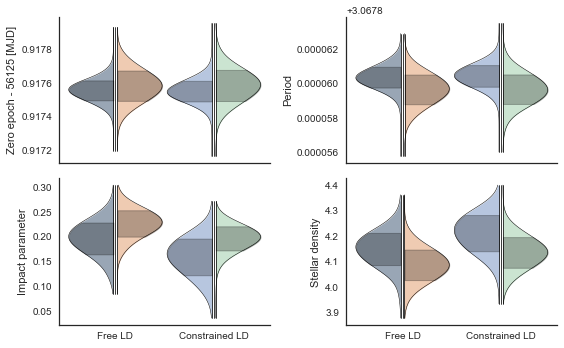

In [13]:
pars = 'tc_centred p b rho'.split()
pnames = 'Zero epoch - 56125 [MJD], Period, Impact parameter, Stellar density'.split(', ')

fig, axs = subplots(2,2, figsize=(8,5))
for i,(p,l) in enumerate(zip(pars, pnames)):
    plot_violin(wf[p], rf[p], axs.flat[i], ylabel=l)
    plot_violin(wl[p], rl[p], axs.flat[i], c=1, ylabel=l)
setp(axs, xticks=[])
setp(axs[1,:], xticks=[0,1], xticklabels='Free LD, Constrained LD'.split(', '))
sb.despine(fig)
fig.tight_layout()

### Radius ratios with free limb darkening 

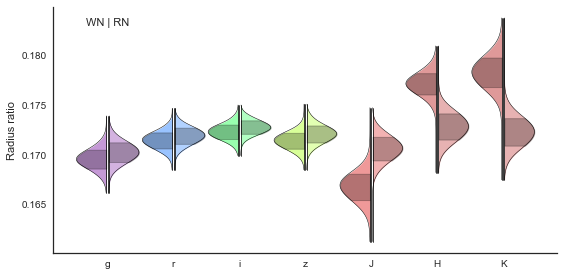

In [14]:
fig,ax = subplots(figsize=(8,4), sharey=True)
for i,c in enumerate(kcols):
    plot_violin(wf[c], rf[c], ax=ax, c=i, color=pbb[i])
setp(ax, ylabel='Radius ratio', xticks=arange(len(passbands)), xticklabels=passbands)
ax.text(0, 0.183, 'WN | RN', ha='center', size=11)
sb.despine(fig)
fig.tight_layout()

### Radius ratios with LDTk

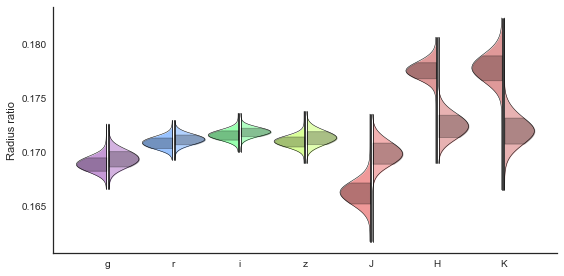

In [15]:
fig,ax = subplots(figsize=(8,4), sharey=True)
for i,c in enumerate(kcols):
    plot_violin(wl[c], rl[c], ax=ax, c=i, color=pbb[i])
setp(ax, ylabel='Radius ratio', xticks=arange(len(passbands)), xticklabels=passbands)
sb.despine(fig)
fig.tight_layout()

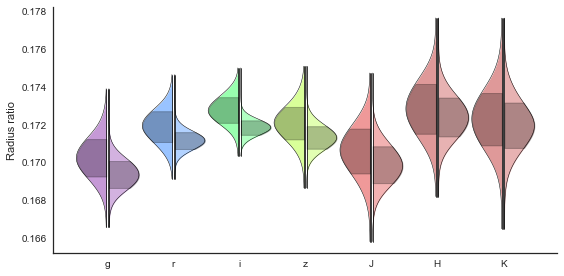

In [16]:
fig,ax = subplots(figsize=(8,4), sharey=True)
for i,c in enumerate(kcols):
    plot_violin(rf[c], rl[c], ax=ax, c=i, color=pbb[i])
setp(ax, ylabel='Radius ratio', xticks=arange(len(passbands)), xticklabels=passbands)
sb.despine(fig)
fig.tight_layout()

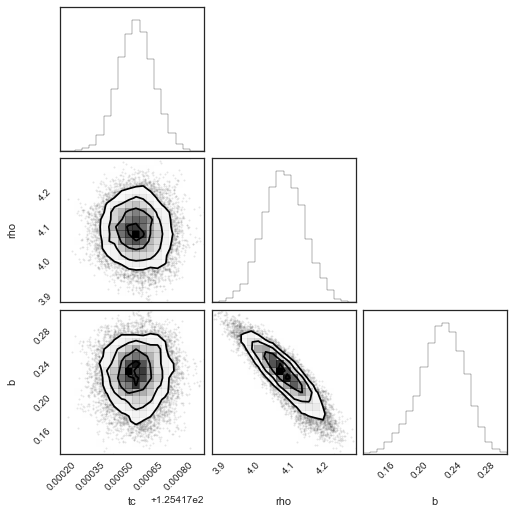

In [17]:
corner(rf['tc rho b'.split()]);

---

<center> &copy; 2017 <a href="mailto:hannu.parviainen@physics.ox.ac.uk">Hannu Parviainen</a></center>